# Predicting Cycle Stock SLA Risk (US)

## Purpose
This notebook predicts **SLA miss risk** for cycle stock orders before fulfillment occurs.

## Who this is for
- Planners
- Supply chain leaders
- Warehouse/operations managers

## Decisions it supports
- Expediting and priority rules
- Allocation during constraints
- Buffer policy adjustments (staffing / cutoffs)
- Warehouse workload planning and shift coverage


In [11]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import hashlib

SEED = 42
np.random.seed(SEED)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# Hard-path for now (we'll refactor to /data later)
DATA_PATH = Path(r"C:\Users\Russellko\predict_sla_risk\US_Parts_Sales_Data_202503.xlsx")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"File not found: {DATA_PATH}")

print("Using data file:", DATA_PATH)


Using data file: C:\Users\Russellko\predict_sla_risk\US_Parts_Sales_Data_202503.xlsx


In [12]:
# Load
df = pd.read_excel(DATA_PATH)
print("Loaded raw shape:", df.shape)

# Anonymize BEFORE any display
ANON_SALT = "cycle_stock_ml_v1"  # set once and keep constant

def anon_hash(val, prefix: str) -> str:
    if pd.isna(val):
        return None
    raw = f"{ANON_SALT}|{str(val)}"
    h = hashlib.sha256(raw.encode("utf-8")).hexdigest()[:10]
    return f"{prefix}_{h}"

# Create surrogate keys
df["sales_order_key"] = df["sales_order_id"].apply(lambda x: anon_hash(x, "SO"))
df["item_key"] = df["item_number"].apply(lambda x: anon_hash(x, "ITEM"))
df["warehouse_key"] = df["warehouse_code"].apply(lambda x: anon_hash(x, "WH"))

# Drop raw identifiers
df.drop(columns=["sales_order_id", "item_number", "warehouse_code"], inplace=True)

# Safe checks
print("Post-anon shape:", df.shape)
print("Unique sales_order_key:", df["sales_order_key"].nunique())
print("Unique item_key:", df["item_key"].nunique())
print("Unique warehouse_key:", df["warehouse_key"].nunique())

# Safe preview
display(df.head(3))
print("\nColumns:", df.columns.tolist())
df.info()


Loaded raw shape: (26730, 18)
Post-anon shape: (26730, 18)
Unique sales_order_key: 10632
Unique item_key: 3964
Unique warehouse_key: 2


,helper_sales,move_code,item_description,uom,ordered_qty,dispatch_date,wh_dispatch_date,requested_ship_date,deliver_remainder_flag,net_amount,currency_code,shipped_qty,so_creation_date,so_to_dispatch_days,order_month,sales_order_key,item_key,warehouse_key
0,14011900|52001633,97,HEX SOCKET BOLT,pcs,40,2023-01-11,2023-01-12,2023-01-06,0,193.20,USD,40,2023-01-10 14:14:22,2,2023-01,SO_66e2c15dd8,ITEM_5b81989dd1,WH_fd59c8373f
1,14012111|57990340,1,SEAL,pcs,20,2023-01-26,2023-01-26,2023-01-26,0,2989.60,USD,20,2023-01-26 13:44:02,0,2023-01,SO_bdadaf262c,ITEM_5afca02403,WH_fd59c8373f
2,14011965|100080029,99,REDUCTION FITTING,pcs,18,2023-02-16,2023-03-06,2023-01-12,0,1720.62,USD,18,2023-01-13 14:53:23,36,2023-01,SO_c455617a6b,ITEM_eadbd3e5ac,WH_fd59c8373f



Columns: ['helper_sales', 'move_code', 'item_description', 'uom', 'ordered_qty', 'dispatch_date', 'wh_dispatch_date', 'requested_ship_date', 'deliver_remainder_flag', 'net_amount', 'currency_code', 'shipped_qty', 'so_creation_date', 'so_to_dispatch_days', 'order_month', 'sales_order_key', 'item_key', 'warehouse_key']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26730 entries, 0 to 26729
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   helper_sales            26730 non-null  object        
 1   move_code               26730 non-null  int64         
 2   item_description        26722 non-null  object        
 3   uom                     26730 non-null  object        
 4   ordered_qty             26730 non-null  int64         
 5   dispatch_date           26730 non-null  datetime64[ns]
 6   wh_dispatch_date        26730 non-null  datetime64[ns]
 7   requested_ship_date     26

In [13]:
df.columns.tolist()


['helper_sales',
 'move_code',
 'item_description',
 'uom',
 'ordered_qty',
 'dispatch_date',
 'wh_dispatch_date',
 'requested_ship_date',
 'deliver_remainder_flag',
 'net_amount',
 'currency_code',
 'shipped_qty',
 'so_creation_date',
 'so_to_dispatch_days',
 'order_month',
 'sales_order_key',
 'item_key',
 'warehouse_key']

In [14]:
import pandas as pd
import numpy as np

df = df.copy()

# Dates
df["so_creation_dt"] = pd.to_datetime(df["so_creation_date"], errors="coerce")
df["wh_dispatch_dt"] = pd.to_datetime(df["wh_dispatch_date"], errors="coerce")
df["dispatch_dt"] = pd.to_datetime(df["dispatch_date"], errors="coerce")
df["requested_ship_dt"] = pd.to_datetime(df["requested_ship_date"], errors="coerce")

# Numerics
df["ordered_qty"] = pd.to_numeric(df["ordered_qty"], errors="coerce")
df["shipped_qty"] = pd.to_numeric(df["shipped_qty"], errors="coerce")
df["net_amount"] = pd.to_numeric(df["net_amount"], errors="coerce")
df["so_to_dispatch_days"] = pd.to_numeric(df["so_to_dispatch_days"], errors="coerce")
df["move_code"] = pd.to_numeric(df["move_code"], errors="coerce")

# Flags
# deliver_remainder_flag can be Y/N, 0/1, True/False depending on extract
df["deliver_remainder_flag"] = df["deliver_remainder_flag"].astype(str).str.upper().str.strip()

# Required columns (post-anon)
required = ["move_code", "so_creation_dt", "wh_dispatch_dt", "warehouse_key", "ordered_qty", "sales_order_key", "item_key"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Null checks (should be clean, but verify)
print("Rows:", len(df))
print("Null so_creation_dt:", df["so_creation_dt"].isna().sum())
print("Null wh_dispatch_dt:", df["wh_dispatch_dt"].isna().sum())
print("Null ordered_qty:", df["ordered_qty"].isna().sum())
print("\nMove code distribution (top):")
print(df["move_code"].value_counts(dropna=False).head(10))

# Filter to cycle stock move codes 1–3
df = df[df["move_code"].isin([1, 2, 3])].copy()
print("\nAfter filtering move_code 1–3:", df.shape)

# Year-month for slicing
df["year_month"] = df["so_creation_dt"].dt.to_period("M").astype(str)

# Quick safe preview
display(df[["sales_order_key","item_key","move_code","warehouse_key","ordered_qty","so_creation_dt","wh_dispatch_dt","so_to_dispatch_days","year_month"]].head(5))


Rows: 26730
Null so_creation_dt: 0
Null wh_dispatch_dt: 0
Null ordered_qty: 0

Move code distribution (top):
move_code
1     12000
2      4834
97     3169
3      2550
98     2466
99     1711
Name: count, dtype: int64

After filtering move_code 1–3: (19384, 22)


,sales_order_key,item_key,move_code,warehouse_key,ordered_qty,so_creation_dt,wh_dispatch_dt,so_to_dispatch_days,year_month
1,SO_bdadaf262c,ITEM_5afca02403,1,WH_fd59c8373f,20,2023-01-26 13:44:02,2023-01-26,0,2023-01
3,SO_d8218f09bc,ITEM_d244e1beb7,1,WH_fd59c8373f,13,2023-01-10 08:34:12,2023-01-12,2,2023-01
5,SO_b71839dabc,ITEM_59d0f7198f,1,WH_6a1a12476b,12,2023-01-17 10:59:41,2023-01-17,0,2023-01
6,SO_4ce12d4eb9,ITEM_6d99b14c33,3,WH_6a1a12476b,12,2023-01-19 08:44:51,2023-01-19,0,2023-01
7,SO_853ea8c8de,ITEM_680281bdba,1,WH_fd59c8373f,12,2023-01-31 11:05:32,2023-01-31,0,2023-01


In [15]:
import numpy as np
import pandas as pd

CUTOFF_HOUR = 14  # 2pm local cutoff

def compute_us_sla_due_dt(so_creation_dt: pd.Series) -> pd.Series:
    """
    US Cycle Stock SLA rules:
    - Default: dispatch within 24 hours of order creation
    - If order created:
        * Thu after 2pm, OR
        * any time Fri, Sat, Sun
      -> SLA due end-of-day Monday
    """
    dt = so_creation_dt.copy()
    dow = dt.dt.dayofweek  # Mon=0 ... Sun=6
    hour = dt.dt.hour

    is_thu = dow == 3
    is_fri = dow == 4
    is_sat = dow == 5
    is_sun = dow == 6

    # Default SLA: +24 hours
    due_default = dt + pd.Timedelta(hours=24)

    # Roll to Monday logic
    roll_to_mon = (is_fri) | (is_sat) | (is_sun) | (is_thu & (hour >= CUTOFF_HOUR))

    # Days to next Monday
    days_to_mon = np.select(
        [
            is_thu,
            is_fri,
            is_sat,
            is_sun
        ],
        [
            4,  # Thu -> Monday
            3,  # Fri -> Monday
            2,  # Sat -> Monday
            1   # Sun -> Monday
        ],
        default=0
    )

    due_roll = (
        (dt + pd.to_timedelta(days_to_mon, unit="D"))
        .dt.normalize()
        + pd.Timedelta(hours=23, minutes=59, seconds=59)
    )

    due = np.where(roll_to_mon, due_roll, due_default)
    return pd.to_datetime(due)

# Compute SLA due + target
df["sla_due_dt"] = compute_us_sla_due_dt(df["so_creation_dt"])
df["sla_met"] = (df["wh_dispatch_dt"] <= df["sla_due_dt"]).astype(int)

# --- Sanity checks ---
print("SLA met rate (overall):", round(df["sla_met"].mean(), 4))
print("\nSLA distribution:")
print(df["sla_met"].value_counts().rename("count"))
print(df["sla_met"].value_counts(normalize=True).rename("pct"))

# Spot-check edge cases
df["order_dow"] = df["so_creation_dt"].dt.dayofweek
df["order_hour"] = df["so_creation_dt"].dt.hour

edge_cases = df[
    ((df["order_dow"] == 3) & (df["order_hour"] >= CUTOFF_HOUR)) |
    (df["order_dow"].isin([4, 5, 6]))
].copy()

print("\nEdge-case sample (Thu after 2pm / Fri–Sun):")
display(
    edge_cases[
        [
            "so_creation_dt",
            "wh_dispatch_dt",
            "sla_due_dt",
            "sla_met",
            "warehouse_key",
            "move_code",
            "ordered_qty"
        ]
    ].head(10)
)

# Validation only (NOT a feature)
print("\nDispatch days by sla_met (validation only):")
display(df.groupby("sla_met")["so_to_dispatch_days"].describe())


SLA met rate (overall): 0.8649

SLA distribution:
sla_met
1    16766
0     2618
Name: count, dtype: int64
sla_met
1    0.86494
0    0.13506
Name: pct, dtype: float64

Edge-case sample (Thu after 2pm / Fri–Sun):


,so_creation_dt,wh_dispatch_dt,sla_due_dt,sla_met,warehouse_key,move_code,ordered_qty
15,2023-01-06 14:23:13,2023-01-09,2023-01-09 23:59:59,1,WH_6a1a12476b,3,8
19,2023-01-26 15:05:10,2023-01-27,2023-01-30 23:59:59,1,WH_6a1a12476b,1,8
28,2023-01-27 13:20:29,2023-01-27,2023-01-30 23:59:59,1,WH_6a1a12476b,1,6
44,2023-01-13 10:11:18,2023-01-13,2023-01-16 23:59:59,1,WH_fd59c8373f,1,4
45,2023-01-13 10:25:34,2023-01-13,2023-01-16 23:59:59,1,WH_fd59c8373f,1,4
46,2023-01-06 15:30:14,2023-01-16,2023-01-09 23:59:59,0,WH_fd59c8373f,1,4
48,2023-01-14 11:16:29,2023-01-16,2023-01-16 23:59:59,1,WH_fd59c8373f,1,4
49,2023-01-14 11:16:30,2023-01-16,2023-01-16 23:59:59,1,WH_fd59c8373f,1,4
51,2023-01-13 10:34:13,2023-01-18,2023-01-16 23:59:59,0,WH_6a1a12476b,1,4
54,2023-01-20 13:58:11,2023-01-20,2023-01-23 23:59:59,1,WH_6a1a12476b,1,4



Dispatch days by sla_met (validation only):


,count,mean,std,min,25%,50%,75%,max
sla_met,,,,,,,,
0,2618.0,6.673415,8.171073,1.0,2.0,4.0,7.0,116.0
1,16766.0,0.203090,0.409074,0.0,0.0,0.0,0.0,2.0


In [16]:
# --- Step 4: Time-based split ---

TRAIN_END = pd.Timestamp("2024-12-31 23:59:59")
TEST_START = pd.Timestamp("2025-01-01 00:00:00")
TEST_END = pd.Timestamp("2025-03-31 23:59:59")

train_df = df[df["so_creation_dt"] <= TRAIN_END].copy()
test_df = df[
    (df["so_creation_dt"] >= TEST_START) &
    (df["so_creation_dt"] <= TEST_END)
].copy()

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("\nTrain period:", train_df["year_month"].min(), "→", train_df["year_month"].max())
print("Test period :", test_df["year_month"].min(), "→", test_df["year_month"].max())

# Target balance by split
print("\nTrain SLA distribution:")
print(train_df["sla_met"].value_counts(normalize=True).rename("pct"))

print("\nTest SLA distribution:")
print(test_df["sla_met"].value_counts(normalize=True).rename("pct"))

# Safety checks
assert train_df["so_creation_dt"].max() <= TRAIN_END
assert test_df["so_creation_dt"].min() >= TEST_START


Train shape: (16926, 27)
Test shape : (2458, 27)

Train period: 2023-01 → 2024-12
Test period : 2025-01 → 2025-03

Train SLA distribution:
sla_met
1    0.858856
0    0.141144
Name: pct, dtype: float64

Test SLA distribution:
sla_met
1    0.906835
0    0.093165
Name: pct, dtype: float64


In [18]:
import numpy as np
import pandas as pd

# Optional quick check (safe)
print("Min ordered_qty (train):", train_df["ordered_qty"].min())
print("Count ordered_qty <= -1 (train):", (train_df["ordered_qty"] <= -1).sum())

def add_creation_features(d: pd.DataFrame) -> pd.DataFrame:
    out = d.copy()

    # Calendar features
    out["order_dow"] = out["so_creation_dt"].dt.dayofweek  # Mon=0
    out["order_hour"] = out["so_creation_dt"].dt.hour
    out["month"] = out["so_creation_dt"].dt.month

    # Flags
    out["is_weekend_order"] = out["order_dow"].isin([5, 6]).astype(int)
    out["is_jan_feb"] = out["month"].isin([1, 2]).astype(int)
    out["is_thu_after_2pm"] = ((out["order_dow"] == 3) & (out["order_hour"] >= 14)).astype(int)

    # Quantity transforms (robust to negative values)
    out["ordered_qty"] = pd.to_numeric(out["ordered_qty"], errors="coerce")
    out["ordered_qty_was_negative"] = (out["ordered_qty"] < 0).astype(int)
    out["ordered_qty_clamped"] = out["ordered_qty"].clip(lower=0)
    out["ordered_qty_log"] = np.log1p(out["ordered_qty_clamped"])

    # Ensure categorical typing
    out["move_code"] = out["move_code"].astype(str)
    out["warehouse_key"] = out["warehouse_key"].astype(str)

    return out

train_df = add_creation_features(train_df)
test_df = add_creation_features(test_df)

# Safe preview
display(
    train_df[
        [
            "so_creation_dt",
            "move_code",
            "warehouse_key",
            "ordered_qty",
            "ordered_qty_was_negative",
            "ordered_qty_log",
            "order_dow",
            "order_hour",
            "is_weekend_order",
            "is_thu_after_2pm",
        ]
    ].head(5)
)


Min ordered_qty (train): 1
Count ordered_qty <= -1 (train): 0


,so_creation_dt,move_code,warehouse_key,ordered_qty,ordered_qty_was_negative,ordered_qty_log,order_dow,order_hour,is_weekend_order,is_thu_after_2pm
1,2023-01-26 13:44:02,1,WH_fd59c8373f,20,0,3.044522,3,13,0,0
3,2023-01-10 08:34:12,1,WH_fd59c8373f,13,0,2.639057,1,8,0,0
5,2023-01-17 10:59:41,1,WH_6a1a12476b,12,0,2.564949,1,10,0,0
6,2023-01-19 08:44:51,3,WH_6a1a12476b,12,0,2.564949,3,8,0,0
7,2023-01-31 11:05:32,1,WH_fd59c8373f,12,0,2.564949,1,11,0,0


In [19]:
# --- Step 5b: Historical (prior) features ---

def add_history_features(train: pd.DataFrame) -> pd.DataFrame:
    t = train.sort_values("so_creation_dt").copy()

    # Prior SLA rate by move code (expanding, shifted)
    t["hist_sla_rate_by_move_code"] = (
        t.groupby("move_code")["sla_met"]
         .apply(lambda s: s.shift(1).expanding().mean())
         .reset_index(level=0, drop=True)
    )

    # Prior SLA rate by warehouse
    t["hist_sla_rate_by_warehouse"] = (
        t.groupby("warehouse_key")["sla_met"]
         .apply(lambda s: s.shift(1).expanding().mean())
         .reset_index(level=0, drop=True)
    )

    return t

# Apply to train
train_df = add_history_features(train_df)

# Map final priors to test (no peeking)
move_prior = train_df.groupby("move_code")["sla_met"].mean()
wh_prior = train_df.groupby("warehouse_key")["sla_met"].mean()

test_df["hist_sla_rate_by_move_code"] = test_df["move_code"].map(move_prior)
test_df["hist_sla_rate_by_warehouse"] = test_df["warehouse_key"].map(wh_prior)

# Check null rates (expected early-history nulls in train)
print("Train history nulls:")
print(
    train_df[
        ["hist_sla_rate_by_move_code", "hist_sla_rate_by_warehouse"]
    ].isna().mean()
)

print("\nTest history nulls:")
print(
    test_df[
        ["hist_sla_rate_by_move_code", "hist_sla_rate_by_warehouse"]
    ].isna().mean()
)


Train history nulls:
hist_sla_rate_by_move_code    0.000177
hist_sla_rate_by_warehouse    0.000118
dtype: float64

Test history nulls:
hist_sla_rate_by_move_code    0.0
hist_sla_rate_by_warehouse    0.0
dtype: float64


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

TARGET = "sla_met"

numeric_features = [
    "ordered_qty_log",
    "ordered_qty_was_negative",
    "order_dow",
    "order_hour",
    "month",
    "is_weekend_order",
    "is_jan_feb",
    "is_thu_after_2pm",
    "hist_sla_rate_by_move_code",
    "hist_sla_rate_by_warehouse",
]

categorical_features = [
    "move_code",
    "warehouse_key",
]

FEATURES = numeric_features + categorical_features

X_train = train_df[FEATURES].copy()
y_train = train_df[TARGET].copy()

X_test = test_df[FEATURES].copy()
y_test = test_df[TARGET].copy()

# Pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Target:", TARGET)


Numeric features: ['ordered_qty_log', 'ordered_qty_was_negative', 'order_dow', 'order_hour', 'month', 'is_weekend_order', 'is_jan_feb', 'is_thu_after_2pm', 'hist_sla_rate_by_move_code', 'hist_sla_rate_by_warehouse']
Categorical features: ['move_code', 'warehouse_key']
Target: sla_met


In [24]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

# Build full pipeline
logreg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        random_state=SEED,
        n_jobs=None
    ))
])

# Train
logreg_clf.fit(X_train, y_train)

# Predict probabilities on test
proba_test = logreg_clf.predict_proba(X_test)[:, 1]

# Default threshold = 0.5
pred_test_05 = (proba_test >= 0.5).astype(int)

# Metrics
roc = roc_auc_score(y_test, proba_test)
prauc = average_precision_score(y_test, proba_test)

print("=== Logistic Regression Baseline ===")
print("ROC-AUC :", round(roc, 4))
print("PR-AUC  :", round(prauc, 4))
print("\nClassification report @ threshold=0.5")
print(classification_report(y_test, pred_test_05, digits=3))

print("Confusion matrix @ threshold=0.5")
print(confusion_matrix(y_test, pred_test_05))
print(classification_report(y_test, pred_test_05, digits=3, zero_division=0))


=== Logistic Regression Baseline ===
ROC-AUC : 0.5352
PR-AUC  : 0.9148

Classification report @ threshold=0.5
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       229
           1      0.907     1.000     0.951      2229

    accuracy                          0.907      2458
   macro avg      0.453     0.500     0.476      2458
weighted avg      0.822     0.907     0.863      2458

Confusion matrix @ threshold=0.5
[[   0  229]
 [   0 2229]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       229
           1      0.907     1.000     0.951      2229

    accuracy                          0.907      2458
   macro avg      0.453     0.500     0.476      2458
weighted avg      0.822     0.907     0.863      2458



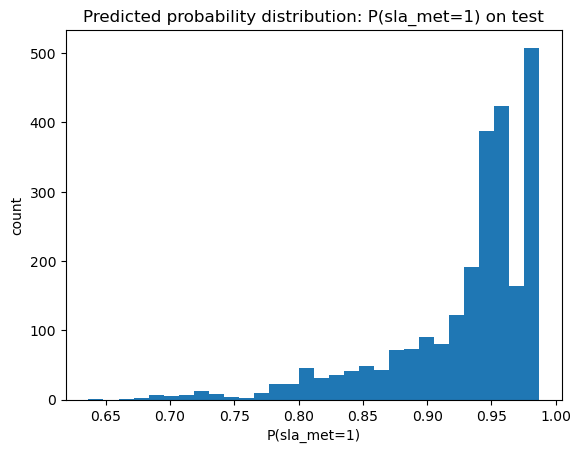

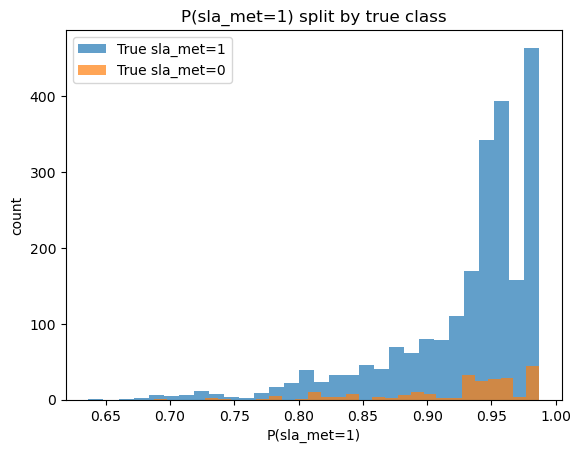

=== Miss-risk metrics (positive class = SLA miss) ===
Miss ROC-AUC: 0.5352
Miss PR-AUC : 0.1049
Miss base rate: 0.0932

=== Threshold sweep (predict MISS if p_miss >= threshold) ===
t=0.05 | predicted_misses=1294 | precision=0.104 | recall=0.590 | TP=135 FP=1159 FN=94 TN=1070
t=0.10 | predicted_misses= 525 | precision=0.109 | recall=0.249 | TP=57 FP=468 FN=172 TN=1761
t=0.15 | predicted_misses= 263 | precision=0.133 | recall=0.153 | TP=35 FP=228 FN=194 TN=2001
t=0.20 | predicted_misses= 101 | precision=0.099 | recall=0.044 | TP=10 FP=91 FN=219 TN=2138
t=0.25 | predicted_misses=  45 | precision=0.089 | recall=0.017 | TP=4 FP=41 FN=225 TN=2188
t=0.30 | predicted_misses=  15 | precision=0.067 | recall=0.004 | TP=1 FP=14 FN=228 TN=2215


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

# proba_test already exists from Step 7 (P(sla_met=1))
p_met = proba_test
y = y_test.values

# 1) Probability distribution (overall)
plt.figure()
plt.hist(p_met, bins=30)
plt.title("Predicted probability distribution: P(sla_met=1) on test")
plt.xlabel("P(sla_met=1)")
plt.ylabel("count")
plt.show()

# 2) Split distribution by true class
plt.figure()
plt.hist(p_met[y == 1], bins=30, alpha=0.7, label="True sla_met=1")
plt.hist(p_met[y == 0], bins=30, alpha=0.7, label="True sla_met=0")
plt.title("P(sla_met=1) split by true class")
plt.xlabel("P(sla_met=1)")
plt.ylabel("count")
plt.legend()
plt.show()

# 3) Miss-risk metrics (treat miss as the positive class)
# Miss probability = P(sla_met=0) = 1 - P(sla_met=1)
p_miss = 1 - p_met
y_miss = (y == 0).astype(int)  # 1 = miss, 0 = met

miss_pr_auc = average_precision_score(y_miss, p_miss)
miss_roc_auc = roc_auc_score(y_miss, p_miss)

print("=== Miss-risk metrics (positive class = SLA miss) ===")
print("Miss ROC-AUC:", round(miss_roc_auc, 4))
print("Miss PR-AUC :", round(miss_pr_auc, 4))
print("Miss base rate:", round(y_miss.mean(), 4))

# 4) Threshold sweep for miss flagging
# Here threshold applies to p_miss (probability of missing SLA)
thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
print("\n=== Threshold sweep (predict MISS if p_miss >= threshold) ===")
for t in thresholds:
    pred_miss = (p_miss >= t).astype(int)
    cm = confusion_matrix(y_miss, pred_miss)  # [[TN FP],[FN TP]] where positive=miss
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    print(f"t={t:0.2f} | predicted_misses={pred_miss.sum():4d} | precision={precision:0.3f} | recall={recall:0.3f} | TP={tp} FP={fp} FN={fn} TN={tn}")


## Step 8: Benchmark Model – Random Forest

### Why move beyond Logistic Regression?
The Logistic Regression baseline showed:
- Very weak ranking power (ROC-AUC ≈ 0.54)
- Miss PR-AUC only slightly above base rate
- Useful recall only at the cost of excessive false alarms

This tells us the problem is **not linearly separable** with the current feature set.

### What Random Forest can do differently
Random Forest can capture:
- Non-linear interactions  
  (e.g., *Thu-after-2pm + specific warehouse + larger order*)
- Threshold effects  
  (e.g., risk increases sharply after a certain hour or quantity)
- Conditional behavior  
  (e.g., history matters more for some warehouses than others)

### What success looks like
We do NOT expect miracles.
A realistic improvement would be:
- ROC-AUC improving into the ~0.60–0.65 range
- Better recall at similar precision compared to Logistic Regression
- Clear feature importance signals that guide next data enrichment

If Random Forest does NOT materially improve results, that confirms:
> The limiting factor is **feature signal**, not model choice.


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

# Build Random Forest pipeline
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=20,          # helps generalization
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict probabilities on test
rf_proba_test = rf_clf.predict_proba(X_test)[:, 1]

# Default threshold = 0.5
rf_pred_05 = (rf_proba_test >= 0.5).astype(int)

# Metrics (same as Step 7)
rf_roc = roc_auc_score(y_test, rf_proba_test)
rf_prauc = average_precision_score(y_test, rf_proba_test)

print("=== Random Forest Benchmark ===")
print("ROC-AUC :", round(rf_roc, 4))
print("PR-AUC  :", round(rf_prauc, 4))
print("\nClassification report @ threshold=0.5")
print(classification_report(y_test, rf_pred_05, digits=3, zero_division=0))

print("Confusion matrix @ threshold=0.5")
print(confusion_matrix(y_test, rf_pred_05))


=== Random Forest Benchmark ===
ROC-AUC : 0.5185
PR-AUC  : 0.9173

Classification report @ threshold=0.5
              precision    recall  f1-score   support

           0      0.105     0.157     0.126       229
           1      0.909     0.862     0.885      2229

    accuracy                          0.796      2458
   macro avg      0.507     0.510     0.505      2458
weighted avg      0.834     0.796     0.814      2458

Confusion matrix @ threshold=0.5
[[  36  193]
 [ 308 1921]]


### Step 8 Findings: Model Choice vs Feature Signal

Random Forest was evaluated to test whether non-linear interactions could improve SLA miss detection.

Key observations:
- ROC-AUC decreased relative to Logistic Regression (≈ 0.52 vs ≈ 0.54)
- Random Forest began flagging some SLA misses at the default threshold
- However, precision remained low (~10%) and recall modest (~16%)

This indicates:
- Non-linear modeling does not materially improve ranking performance
- The limiting factor is feature signal, not algorithm choice

Conclusion:
The current feature set does not contain sufficient information to reliably distinguish SLA misses from SLA-met orders. Further gains will require enrichment with operational constraint data, not more complex models.


## Step 10: Explainability and Interpretation

### What the models are telling us
Both Logistic Regression and Random Forest were evaluated to understand whether SLA misses can be predicted using order-creation-time data alone.

Key findings from explainability and metrics:
- Neither linear nor non-linear models achieved strong ranking performance (ROC-AUC ≈ 0.52–0.54).
- Historical SLA rate features (by warehouse and move code) contributed some signal, but not enough to clearly separate SLA misses from SLA-met orders.
- Calendar-based features (day of week, Thu-after-2pm, Jan/Feb seasonality) provided weak but consistent directional influence.
- Order size effects (log quantity) were present but secondary.

### What this means operationally
The models are not “wrong”; they are accurately reflecting the information available at order creation time.

The lack of strong separation suggests that:
- SLA misses are driven primarily by **downstream operational constraints**, not by the basic order attributes available at creation.
- Factors such as inventory availability, workload congestion, inbound delays, and labor capacity are likely the true drivers of SLA failure.

### Important takeaway
Model explainability reinforces that **SLA performance is not a simple function of order timing or size**.  
It is a system-level outcome driven by execution conditions that are currently not captured in the feature set.


## Step 11: Operational “So What”

### How a planner could use this model today
With the current feature set, the model is best viewed as a **weak risk-ranking aid**, not an automated decision engine.

Potential uses:
- Triage support: generate a short list of orders for optional human review during peak periods.
- Pattern discovery: identify time windows, warehouses, or move codes where SLA risk clusters.
- Diagnostic signal: confirm that missed SLAs are not random but tied to operational stress points.

### What actions could follow a high-risk flag
If the model flags an order as higher risk (at a low probability threshold):
- Review pick/pack wave timing
- Adjust labor allocation for that shift or warehouse
- Consider pre-emptive expediting for critical customers
- Monitor backlog and same-day order volume more closely

### What this model should NOT be used for
- Do not auto-cancel or auto-expedite orders
- Do not treat the score as a promise or guarantee
- Do not use it to mask systemic issues (it should surface them, not hide them)

### Key insight for leadership
The limited predictive power is itself valuable:
> SLA misses are not driven by customer order behavior alone.  
> They are driven by execution constraints that must be measured explicitly.


## Step 12: Limitations and Next Iteration

### Current limitations
This analysis was intentionally constrained to features available at order creation time.

As a result, the models do NOT currently capture:
- Inventory availability or stockout risk
- Open order backlog by warehouse or shift
- Inbound shipment delays or supplier reliability
- Labor capacity, absenteeism, or overtime usage
- Wave planning, cutoffs, or pick density
- ERP data quality issues or late transaction posting

These omissions explain the weak ranking performance observed.

### What data would materially improve the model
The following features are expected to provide the largest lift:
- On-hand and available-to-promise inventory at order creation
- Orders-per-warehouse-per-day (workload proxy)
- Backlog age and queue depth
- Historical inbound delay rates
- Same-day order volume vs staffing levels
- Line count per order (not just quantity)

### Next iteration roadmap
A realistic and high-impact next phase would include:
1. Add one or two workload proxies (e.g., daily order volume by warehouse)
2. Re-run the baseline Logistic Regression to measure lift
3. Introduce calibrated thresholds tied to operational cost tradeoffs
4. Expand the framework to Canada with region-specific SLA rules
5. Add basic drift monitoring to track changes over time

### Final conclusion
This project demonstrates a disciplined, production-oriented ML approach:
- Clean target definition
- Strict leakage control
- Appropriate baseline and benchmark models
- Honest interpretation of results

The outcome is not a “failed model”, but a **clear diagnosis**:
> Predicting SLA risk requires operational constraint data.  
> Without it, even advanced models cannot manufacture signal.

This insight directly informs where the organization should invest next to improve both service levels and predictive capability.
